EDA

In [117]:
# Importing Libraries
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
import librosa.display
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM,Bidirectional
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

In [ ]:
# Sample audio file
file_name=r"..\data\cv-corpus-10.0-delta-2022-07-04\en\clips\common_voice_en_31832758.mp3"





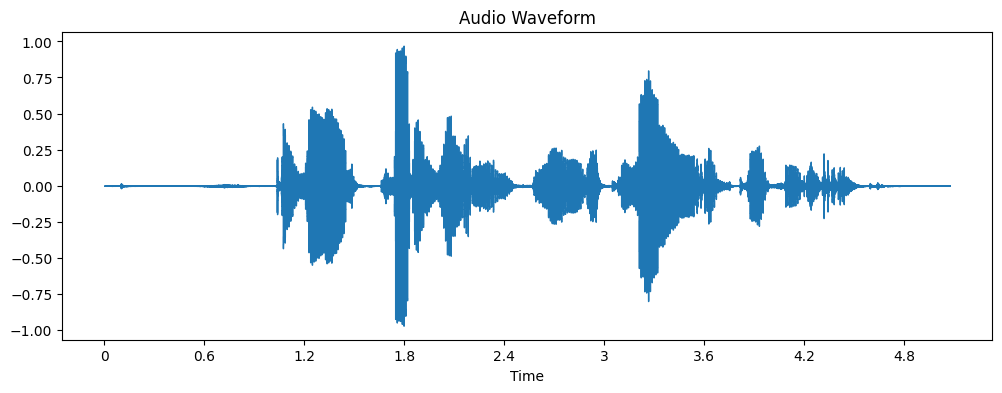

In [98]:
# Plotting audio data using matplotlib and librosa

plt.figure(figsize=(12, 4))
audio, sr = librosa.load(file_name)
librosa.display.waveshow(audio, sr=sr)
plt.title("Audio Waveform")
plt.savefig("../reports/waveform.png")
plt.show()




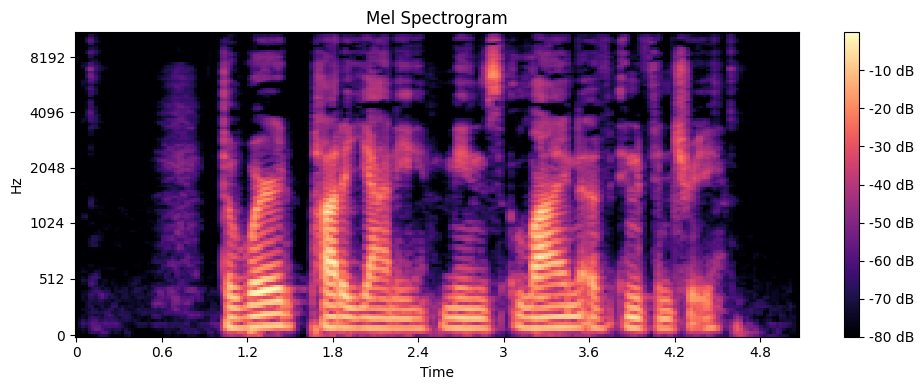

In [100]:
y, sr = librosa.load(file_name)

# Compute spectrogram (in dB)
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

# Display
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.savefig("../reports/Mel_Spectogram.png")
plt.show()

In [15]:
print(sample_rate)

22050


In [16]:
print(data)

[-2.0395114e-18 -5.5638546e-18 -2.8318336e-17 ...  1.4311105e-07
  1.0175306e-07  0.0000000e+00]


In [46]:

df=pd.read_csv(r"..\data\cv-corpus-10.0-delta-2022-07-04\en\validated.tsv",sep="\t")

In [47]:
df.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,locale,segment
0,00d443b51ccb99c6c13ca3427678080ece4fc5aefe9cb6...,common_voice_en_32371106.mp3,Coles Branch is underlaid by the Deep River Ba...,2,0,sixties,male,NaN,en,NaN
1,020f00302b130a7f0094fcf65c580e502b2584e68b0bb5...,common_voice_en_32646599.mp3,It serves to support many other works.,2,0,NaN,NaN,NaN,en,NaN
2,024294f8be5085910eb128966779b03f2ea3669ed55bf5...,common_voice_en_32703291.mp3,He was the chief clerk of the Chicago and Nort...,4,2,NaN,NaN,NaN,en,NaN
3,05bf98ddeee61ab852955ee2bae7296140b7f7da622b66...,common_voice_en_32542436.mp3,Other collaborations on the project include Jo...,2,0,NaN,NaN,United States English,en,NaN
4,06c53aec09bca54d5587147ee1bfcc0a9e2b4162fb75da...,common_voice_en_32825553.mp3,Finally he returns home to rebuild and rehabil...,2,0,fourties,male,Irish English,en,NaN


In [48]:
df.isnull().sum() # checking null value in dataset

client_id        0
path             0
sentence         0
up_votes         0
down_votes       0
age           2583
gender        2603
accents       1083
locale           0
segment       9590
dtype: int64

In [ ]:
df.duplicated().sum() # Checking duplicated  values

0

In [ ]:
# taking only two categories Male and Female
df = df[(df['gender'] == 'male') | (df['gender'] == 'female')]

In [40]:
df.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,locale,segment
0,00d443b51ccb99c6c13ca3427678080ece4fc5aefe9cb6...,common_voice_en_32371106.mp3,Coles Branch is underlaid by the Deep River Ba...,2,0,sixties,male,NaN,en,NaN
4,06c53aec09bca54d5587147ee1bfcc0a9e2b4162fb75da...,common_voice_en_32825553.mp3,Finally he returns home to rebuild and rehabil...,2,0,fourties,male,Irish English,en,NaN
5,0716c31f93060f09df88184c88e347d6e191286ef6d3b6...,common_voice_en_32661886.mp3,It has also been identified in Soviet involvem...,2,0,fourties,male,England English,en,NaN
7,07d3d922297a7ff95c0af1273ea9511f05d9e73ad7eccb...,common_voice_en_32133713.mp3,He was employed in the coal industry before as...,2,0,twenties,male,NaN,en,NaN
8,07f310f0cc039ba964ea9c79e060ca7dee1abf0483339d...,common_voice_en_32681548.mp3,Eleven of the losses were by six points are fe...,2,0,fourties,male,United States English,en,NaN


In [45]:
df.isnull().sum()

client_id        0
path             0
sentence         0
up_votes         0
down_votes       0
age             79
gender           0
accents        328
locale           0
segment       6685
dtype: int64

In [41]:
df['gender'].value_counts()

gender
male      3469
female    3216
Name: count, dtype: int64

<Axes: title={'center': 'Gender Distribution'}, xlabel='gender'>

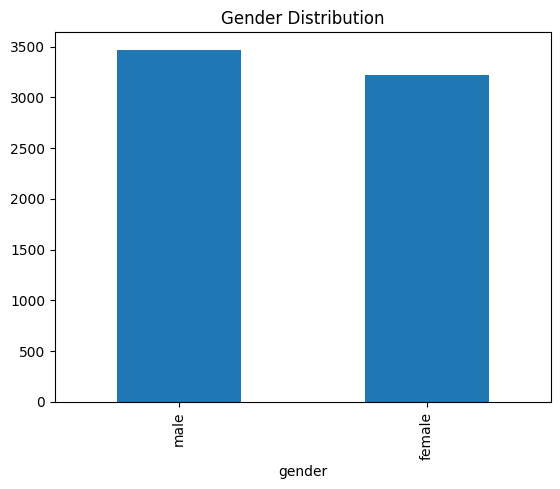

In [42]:
df['gender'].value_counts().plot(kind='bar', title='Gender Distribution')

There are no much difference in both categories So our Dataset is Balanced

Data Preprocessing

In [51]:
DATA_PATH = r"C:\Users\ys136\Desktop\Generative AI\intern tasks\Voice_Classification\data\cv-corpus-10.0-delta-2022-07-04\en\clips" #  Providing audio datapath
METADATA_PATH = r"C:\Users\ys136\Desktop\Generative AI\intern tasks\Voice_Classification\data\cv-corpus-10.0-delta-2022-07-04\en\validated.tsv"  # Providing Meta Data Path

In [ ]:
# Load metadata and audio file paths
def load_metadata():
    df = pd.read_csv(METADATA_PATH, sep='\t')
    df = df[['path', 'gender']]
    df = df[(df['gender'] == 'male') | (df['gender'] == 'female')]
    df_labeled= df.dropna(subset=['gender'])
    df_unlabeled = df[df['gender'].isna()]

    df_labeled['path'] = DATA_PATH + '/' + df_labeled['path']
    return df_labeled

In [57]:
metadata=load_metadata()
metadata.head()

,path,gender
0,C:\Users\ys136\Desktop\Generative AI\intern ta...,male
4,C:\Users\ys136\Desktop\Generative AI\intern ta...,male
5,C:\Users\ys136\Desktop\Generative AI\intern ta...,male
7,C:\Users\ys136\Desktop\Generative AI\intern ta...,male
8,C:\Users\ys136\Desktop\Generative AI\intern ta...,male


In [58]:
metadata['path'][0]

'C:\\Users\\ys136\\Desktop\\Generative AI\\intern tasks\\Voice_Classification\\data\\cv-corpus-10.0-delta-2022-07-04\\en\\clips/common_voice_en_32371106.mp3'

In [59]:
metadata['gender'].value_counts()

gender
male      3469
female    3216
Name: count, dtype: int64

In [ ]:
# Feature extractor (keep time steps)
def feature_extractor(file):
    audio,sample_rate=librosa.load(file,res_type="Kaiser_fast")
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    return   mfccs_features.T

In [62]:
# Extract features from dataset
extracted_features=[]
max_pad_len=100 # pad/truncate all MFCC sequences to this length
for _, row in tqdm(metadata.iterrows(), total=len(metadata)):
    try:
        mfcc = feature_extractor(row["path"])
        if mfcc.shape[0] < max_pad_len:
            pad_width = max_pad_len - mfcc.shape[0]
            mfcc = np.pad(mfcc, pad_width=((0, pad_width), (0, 0)), mode='constant')
        else:
            mfcc = mfcc[:max_pad_len, :]
        extracted_features.append([mfcc, row["gender"]])
    except:
        continue

100%|██████████| 6685/6685 [30:46<00:00,  3.62it/s]  


In [63]:
extracted_features

[[array([[-5.3037903e+02,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [-5.3037903e+02,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [-5.3037903e+02,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         ...,
         [-2.0954810e+02,  1.1393527e+02, -2.2423553e+00, ...,
          -1.0323396e+01,  1.5789645e+00,  1.0424765e+01],
         [-1.8672409e+02,  1.5058789e+02, -1.8922066e+01, ...,
          -1.2690651e+00, -3.3634639e-01,  8.4192429e+00],
         [-1.9700987e+02,  1.7601556e+02, -3.0847464e+01, ...,
           2.3684371e+00,  7.8270264e-02,  6.4131708e+00]], dtype=float32),
  'male'],
 [array([[-6.1831213e+02,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [-6.1389844e+02,  5.1730409e+00,  2.9995677e+00, ...,
          -2.3851643e+00, -1.6983447e+00,

In [88]:
# Prepare feature 
extracted_features_df=pd.DataFrame(data=extracted_features,columns=['features','gender'])
extracted_features_df.head()



,features,gender
0,"[[-530.379, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",male
1,"[[-618.31213, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",male
2,"[[-570.2077, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",male
3,"[[-607.6068, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",male
4,"[[-514.8181, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",male


In [65]:
# Prepare  label arrays
x=np.array(extracted_features_df['features'].to_list())
y_labels=np.array(extracted_features_df['gender'].to_list())

In [73]:
# Encode labels
labelencoder=LabelEncoder()
y_encoded=labelencoder.fit_transform(y_labels)
y=to_categorical(y_encoded)


In [74]:
print(x)

[[[-5.30379028e+02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-5.30379028e+02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-5.30379028e+02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [-2.09548096e+02  1.13935272e+02 -2.24235535e+00 ... -1.03233957e+01
    1.57896447e+00  1.04247646e+01]
  [-1.86724091e+02  1.50587891e+02 -1.89220657e+01 ... -1.26906514e+00
   -3.36346388e-01  8.41924286e+00]
  [-1.97009872e+02  1.76015564e+02 -3.08474636e+01 ...  2.36843705e+00
    7.82702640e-02  6.41317081e+00]]

 [[-6.18312134e+02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-6.13898438e+02  5.17304087e+00  2.99956775e+00 ... -2.38516426e+00
   -1.69834471e+00 -1.33920908e+00]
  [-5.86155945e+02  2.16884651e+01  7.67311478e+00 ... -6.34620237e+00
    6.53458834e-01  6.51580095e-01]
  ...
  [-3.00904968e+02  1.1

In [75]:
print(y)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [76]:
print(x.shape,y.shape)

(6685, 100, 40) (6685, 2)


In [77]:
# Train test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [78]:
print(X_train.shape,y_train.shape)

(5348, 100, 40) (5348, 2)


Model Creation

In [79]:
print(X_train)

[[[-5.79017334e+02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-5.79017334e+02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-5.79017334e+02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [-3.64503265e+02  1.39136688e+02 -1.20976515e+01 ...  2.51919961e+00
    1.63080025e+00  3.03610182e+00]
  [-3.72152039e+02  1.53960632e+02  1.01082478e+01 ...  4.74461460e+00
    2.58960032e+00  6.90757215e-01]
  [-4.03996368e+02  1.66910294e+02  3.83248520e+01 ...  6.64934969e+00
    5.64668179e+00 -2.58499503e+00]]

 [[-6.63928528e+02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-4.67286560e+02 -2.18266182e+01 -4.19357834e+01 ... -3.25270510e+00
   -1.56152201e+00 -9.42777157e-01]
  [-3.72129425e+02 -2.48185310e+01 -5.05257416e+01 ... -7.40968108e-01
   -1.72227943e+00 -1.35855663e+00]
  ...
  [-2.39999435e+02  7.0

In [82]:
# Compute class weights
cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_encoded), y=y_encoded)
cw_dict = dict(enumerate(cw))

In [118]:
# Model definition
cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_encoded), y=y_encoded)
cw_dict = dict(enumerate(cw))
# BiLSTM model definition
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=False), input_shape=(100, 40)),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_test, y_test), class_weight=cw_dict,callbacks=[EarlyStopping(patience=3)])




Epoch 1/30
168/168 [==============================] - 108s 557ms/step - loss: 0.4063 - accuracy: 0.8171 - val_loss: 0.1382 - val_accuracy: 0.9619
Epoch 2/30
168/168 [==============================] - 95s 568ms/step - loss: 0.2020 - accuracy: 0.9273 - val_loss: 0.1302 - val_accuracy: 0.9611
Epoch 3/30
168/168 [==============================] - 88s 523ms/step - loss: 0.1469 - accuracy: 0.9521 - val_loss: 0.1084 - val_accuracy: 0.9708
Epoch 4/30
168/168 [==============================] - 81s 480ms/step - loss: 0.1310 - accuracy: 0.9546 - val_loss: 0.1036 - val_accuracy: 0.9716
Epoch 5/30
168/168 [==============================] - 83s 492ms/step - loss: 0.1271 - accuracy: 0.9577 - val_loss: 0.0933 - val_accuracy: 0.9731
Epoch 6/30
168/168 [==============================] - 131s 783ms/step - loss: 0.1127 - accuracy: 0.9639 - val_loss: 0.1025 - val_accuracy: 0.9731
Epoch 7/30
168/168 [==============================] - 108s 642ms/step - loss: 0.1046 - accuracy: 0.9652 - val_loss: 0.1121 - val

In [131]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
report=classification_report(y_true_labels, y_pred_labels, target_names=labelencoder.classes_)
print(report)


42/42 [==============================] - 9s 201ms/step
              precision    recall  f1-score   support

      female       0.95      0.99      0.97       623
        male       0.99      0.96      0.97       714

    accuracy                           0.97      1337
   macro avg       0.97      0.97      0.97      1337
weighted avg       0.97      0.97      0.97      1337



Test Prdiction

In [92]:
def preprocess_audio(file_path):
    y, sr = librosa.load(file_path, res_type='kaiser_fast')
    y, _ = librosa.effects.trim(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T
    if mfcc.shape[0] < max_pad_len:
        pad_width = max_pad_len - mfcc.shape[0]
        mfcc = np.pad(mfcc, pad_width=((0, pad_width), (0, 0)), mode='constant')
    else:
        mfcc = mfcc[:max_pad_len, :]
    return mfcc.reshape(1, max_pad_len, 40)

In [94]:
test_file = r"C:\Users\ys136\Desktop\Generative AI\intern tasks\Voice_Classification\samples\test_female.mp3"  # keep mp3 as you trained on mp3
features = preprocess_audio(test_file)
prediction = model.predict(features)
print(prediction)
predicted_class = labelencoder.inverse_transform([np.argmax(prediction)])
print("Predicted Gender:", predicted_class[0])

1/1 [==============================] - 0s 142ms/step
[[0.9984181  0.00158196]]
Predicted Gender: female


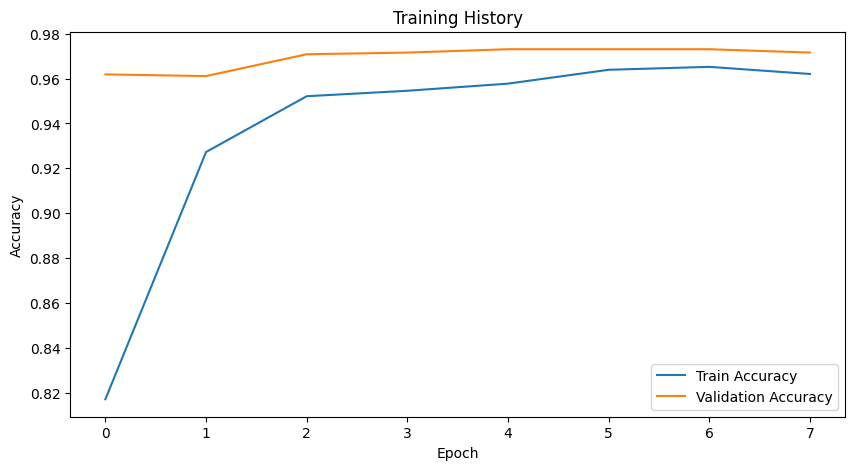

In [128]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('../reports/training_history.png')

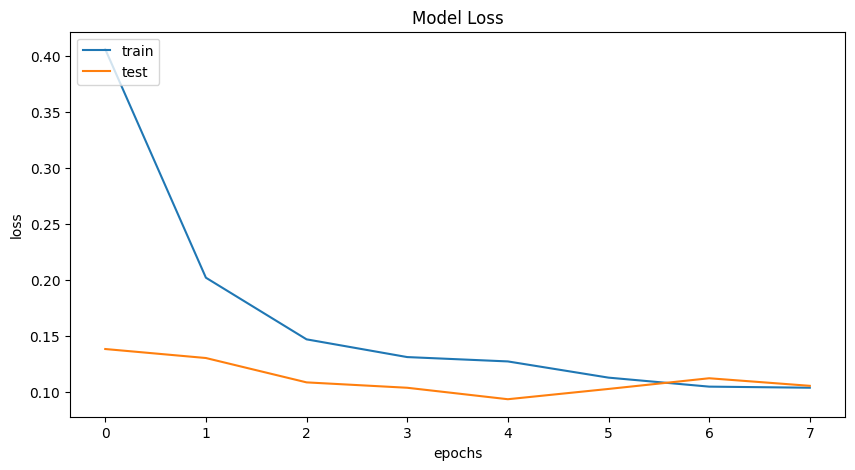

In [130]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel('epochs')
plt.legend(['train','test'],loc='upper left')
plt.show()